In [1]:
from mplsoccer import Sbopen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import streamlit as st
from joblib import load
from db_connection import get_db

In [2]:
statsbomb_api = Sbopen()
db = next(get_db())
competition_list = statsbomb_api.competition()
competitions = competition_list[~competition_list['match_available_360'].isna()]

matches = []
#competition = {"competition_id": 55, "season_id": 282, "name": "EURO_2024"},
for _, competition in competitions.iterrows():
    if  competition.season_id == 282:
        df_match = statsbomb_api.match(competition_id=competition['competition_id'] , season_id=competition['season_id'])
        new = df_match.match_id.unique()
        matches.extend(new)

In [3]:
len(set(matches))

51

In [4]:
import time

event_df = pd.DataFrame()
track_df = pd.DataFrame()
    
for match in matches:
    try:
        df = statsbomb_api.event(match)
        df2 = statsbomb_api.frame(match)
        df_event = df[0]
        df_track = df2[0]
        event_df = pd.concat([event_df, df_event], ignore_index=True)
        track_df = pd.concat([track_df, df_track], ignore_index=True)
        event_df.reset_index(drop=True, inplace=True)
        track_df.reset_index(drop=True, inplace=True)
    except:
        print('except')
        time.sleep(1)

In [5]:
event_df = event_df.dropna(subset=['x', 'y'])
event_df = event_df[~event_df[['x', 'y']].isin([float('inf'), float('-inf')]).any(axis=1)]

In [ ]:
event_df[event_df[['end_x', 'end_y']].isna().any(axis=1)].type_name.value_counts()

type_name
Ball Receipt         51618
Pressure             14544
Ball Recovery         4130
Duel                  3059
Block                 1992
Clearance             1852
Foul Committed        1317
Dribble               1280
Foul Won              1271
Miscontrol            1100
Dispossessed           976
Interception           813
Goal Keeper            730
Dribbled Past          712
50/50                  293
Referee Ball-Drop      121
Shield                  52
Error                   38
Offside                 15
Own Goal Against        10
Own Goal For            10
Name: count, dtype: int64

In [7]:
# if no end => start == end
event_df.loc[event_df['end_x'].isna(), 'end_x'] = event_df['x']
event_df.loc[event_df['end_y'].isna(), 'end_y'] = event_df['y']

In [ ]:
event_df = event_df.sort_values(by=['match_id', 'period', 'timestamp'])
event_df_possession_team=event_df[event_df['team_name'] == event_df['possession_team_name']]
# Get first event in each possession
possession_start = event_df_possession_team.groupby(['match_id', 'possession']).first().reset_index()

# Get last event in each possession
possession_end = event_df_possession_team.groupby(['match_id', 'possession']).last().reset_index()



# Merge to have start and end locations
df_possessions = possession_start[['match_id', 'possession', 'team_id', 'team_name', 'x', 'y', 'type_name']].rename(
    columns={'x': 'start_x', 'y': 'start_y', 'type_name': 'start_event'}
).merge(
    possession_end[['match_id', 'possession', 'x', 'y', 'type_name']], 
    on=['match_id', 'possession'], 
    how='left'
).rename(
    columns={'x': 'end_x', 'y': 'end_y', 'type_name': 'end_event'}
)
possession_end.loc[:,['possession_team_name', 'team_name', 'x']]

,possession_team_name,team_name,x
0,Germany,Germany,97.1
1,Scotland,Scotland,78.3
2,Germany,Germany,103.8
3,Scotland,Scotland,62.1
4,Scotland,Scotland,87.7
...,...,...,...
8005,Spain,Spain,81.1
8006,England,England,40.7
8007,England,England,57.9
8008,England,England,105.5


In [9]:
# Count occurrences of start and end events
start_event_counts = df_possessions['start_event'].value_counts()
end_event_counts = df_possessions['end_event'].value_counts()

# Print insights
print("Most common possession start events:")
print(start_event_counts)

print("\nMost common possession end events:")
print(end_event_counts)


Most common possession start events:
start_event
Pass                 5818
Ball Recovery        1145
Duel                  401
Goal Keeper           277
Interception          148
Referee Ball-Drop     121
Shot                   83
Block                  10
50/50                   7
Name: count, dtype: int64

Most common possession end events:
end_event
Ball Receipt         2635
Shot                  958
Pass                  943
Foul Won              841
Miscontrol            459
Dispossessed          442
Pressure              339
Duel                  312
Dribble               302
Foul Committed        281
Goal Keeper           136
Block                  91
Referee Ball-Drop      90
Ball Recovery          58
50/50                  34
Clearance              28
Interception           14
Shield                 13
Offside                12
Own Goal For           10
Carry                   5
Dribbled Past           5
Error                   2
Name: count, dtype: int64


# 🏟️ Step 1: Define Pitch Zones


In [10]:
print(event_df['x'].min(),event_df['x'].max())
print(event_df['y'].min(),event_df['y'].max())

0.1 120.1
0.1 80.0


In [11]:
def get_pitch_zone(x, y):
    # Define horizontal zones (x-axis)
    if x < 40:
        horiz_zone = 'Defensive'
    elif x <= 80:
        horiz_zone = 'Middle'
    else:
        horiz_zone = 'Attacking'

    # Define vertical zones (y-axis)
    if y < 20:
        vert_zone = 'Right'
    elif y <= 60:
        vert_zone = 'Center'
    else:
        vert_zone = 'Left'
    
    return f"{horiz_zone} {vert_zone}"

# Apply function to create start and end zones
event_df['start_zone'] = event_df.apply(lambda row: get_pitch_zone(row['x'], row['y']), axis=1)
event_df['end_zone'] = event_df.apply(lambda row: get_pitch_zone(row['end_x'], row['end_y']), axis=1)


In [12]:
df_event = event_df

# 🏃‍♂️ Step 2: Compute Movement Features

In [13]:
df_event['distance'] = np.sqrt((df_event['x'] - df_event['end_x']) ** 2 + (df_event['y'] - df_event['end_y']) ** 2)
df_event['progression'] = df_event['end_x'] - df_event['x']
df_event['directness'] = np.where(df_event['distance'] != 0, df_event['progression'] / df_event['distance'], 0)
df_event['width_change'] = abs(df_event['end_y'] - df_event['y'])
df_event['speed'] = np.where(df_event['duration'] != 0, df_event['distance'] / df_event['duration'], 0)
df_event['distance_covered'] = np.sqrt((df_event['end_x'] - df_event['x']) ** 2 + (df_event['end_y'] - df_event['y']) ** 2)
df_event['angle_change'] = np.arctan2(df_event['end_y'] - df_event['y'], df_event['end_x'] - df_event['x'])

Packing Metrics

In [14]:
id_pos = event_df.loc[:,['id', 'x', 'y', 'end_x', 'end_y']]
id_pos = id_pos.rename(columns={'x': 'ball_x', 'y': 'ball_y'})
track_df_full = track_df.merge(id_pos, on='id', how='left')
track_df_full = track_df_full[track_df_full['actor']==False]
track_df_full['distance'] = np.sqrt((track_df_full['x'] - track_df_full['ball_x'])**2 + (track_df_full['y'] - track_df_full['ball_y'])**2)

track_df_full['packing'] = (track_df_full['x'] > track_df_full['ball_x']) & (track_df_full['x'] < track_df_full['end_x'])
teammates_df = track_df_full[track_df_full['teammate'] == True]
teammates_df = teammates_df.rename(columns={'distance': 'teammate_distance'})
opponents_df = track_df_full[track_df_full['teammate'] == False]
opponents_df = opponents_df.rename(columns={'distance': 'opponent_distance'})
track_df_full['nearby_opponents'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==False)
track_df_full['nearby_teammates'] = (track_df_full['distance'] < 10) & (track_df_full['teammate']==True)


teammate_distance_min = teammates_df.groupby(['id'])['teammate_distance'].min().reset_index()
opponent_distance_min = opponents_df.groupby('id')['opponent_distance'].min().reset_index()
distance_count = track_df_full.groupby('id')['nearby_opponents'].sum().reset_index()
distance_count_teammates = track_df_full.groupby('id')['nearby_teammates'].sum().reset_index()
packing = opponents_df.groupby('id')['packing'].sum().reset_index()
#packing_metric = 


df_event = df_event.merge(distance_count, on='id', how='left')
df_event = df_event.merge(distance_count_teammates, on='id', how='left')
df_event = df_event.merge(teammate_distance_min, on='id', how='left')
df_event = df_event.merge(opponent_distance_min, on='id', how='left')
df_event = df_event.merge(packing, on='id', how='left')

In [15]:
def calculate_packing_metric2(event, track_df, threshold=3):
    event_id = event["id"]
    start_x, start_y, end_x, end_y = event["x"], event["y"], event["end_x"], event["end_y"]
    
    # Retrieve opponent positions for the given event
    opponents = track_df.loc[(track_df["id"] == event_id) & (track_df["teammate"] == False), ["x", "y"]]

    if opponents.empty:
        return 0  # No opponents present
    
    # Vectorized point-to-line distance calculation
    dx = end_x - start_x
    dy = end_y - start_y
    line_length_sq = dx**2 + dy**2

    if line_length_sq == 0:
        return 0  # No movement, no packing

    # Projection factor t for each opponent
    t = ((opponents["x"] - start_x) * dx + (opponents["y"] - start_y) * dy) / line_length_sq
    t = np.clip(t, 0, 1)  # Ensure projections are within segment

    # Closest points on the action path
    closest_x = start_x + t * dx
    closest_y = start_y + t * dy

    # Euclidean distances from opponents to action path
    distances = np.sqrt((opponents["x"] - closest_x)**2 + (opponents["y"] - closest_y)**2)

    # Count opponents within the threshold distance
    return np.sum(distances < threshold)

#df_event["packing_metric"] = df_event.apply(calculate_packing_metric2, track_df=track_df, threshold=3, axis=1)

In [16]:
df_event.foul_won_defensive.value_counts()    

foul_won_defensive
True    390
Name: count, dtype: int64

# 📊 Possession level aggregation


In [17]:
df_pressure = df_event.groupby(['match_id', 'possession'])['under_pressure'].sum().reset_index()
df_pressure.rename(columns={'under_pressure': 'pressure_count'}, inplace=True)

# Count event types 
df_counts = df_event.groupby(['match_id', 'possession'])['type_name'].value_counts().unstack(fill_value=0).reset_index()
df_counts = df_counts[['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel', 'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance']].fillna(0)

df_pass = df_event[(df_event['type_name'] == 'Pass') & (df_event['team_name'] == df_event['possession_team_name'])].groupby(['match_id', 'possession']).agg(
    all_passes = ('pass_length', 'count'),
    successful_passes = ('outcome_name', lambda x: (x.isin([np.nan, 'Complete', 'Success', 'Success In Play', 'Success To Team'])).sum()),
    avg_pass_length = ('pass_length', 'mean'),
    avg_pass_angle = ('pass_angle', 'mean'),
    longest_forward_pass = ('progression', 'max')
).reset_index()
df_pass['pass_success_rate'] = df_pass['successful_passes'] / df_pass['all_passes']
df_pass.fillna(0, inplace=True)

# Merge pass-related features into df_counts
df_counts = df_counts.merge(df_pass[['match_id', 'possession', 'successful_passes','all_passes', 'avg_pass_length', 'avg_pass_angle', 'pass_success_rate', 'longest_forward_pass']], 
                            on=['match_id', 'possession'], how='left')

# Aggregate movement features
df_movement = df_event.groupby(['match_id', 'possession']).agg(
    total_distance=('distance', 'sum'),
    avg_progression=('progression', 'mean'),
    avg_directness=('directness', 'mean'),
    total_width_change=('width_change', 'sum'),
    avg_speed=('speed', 'mean')
).reset_index()


df_pass_types = df_event[df_event['type_name'] == 'Pass'].groupby(['match_id', 'possession'])['pass_height_name'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pass_types.columns = ['match_id', 'possession'] + [f'{col.lower().replace(" ", "_")}' for col in df_pass_types.columns[2:]]

# Aggregate pitch zone counts (start zones)
df_pitch_zones = df_event.groupby(['match_id', 'possession'])['start_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones.columns = ['match_id', 'possession'] + [f'start_{col.lower().replace(" ", "_")}' for col in df_pitch_zones.columns[2:]]

# Aggregate pitch zone counts (end zones)
df_pitch_zones_end = df_event.groupby(['match_id', 'possession'])['end_zone'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
df_pitch_zones_end.columns = ['match_id', 'possession'] + [f'end_{col.lower().replace(" ", "_")}' for col in df_pitch_zones_end.columns[2:]]


# Attacking effectiveness
df_attacking = df_event.groupby(['match_id', 'possession']).agg(total_xg=('shot_statsbomb_xg', 'sum')).reset_index()

# Pressure & support
df_pressure_support = df_event.groupby(['match_id', 'possession']).agg(
    avg_opponent_distance=('opponent_distance', 'mean'),
    avg_teammate_distance=('teammate_distance', 'mean'),
    avg_opponent_count=('nearby_opponents', 'mean'),
    avg_teammate_count=('nearby_teammates', 'mean')).reset_index()


# Packing sum
df_packing = df_event.groupby(['match_id', 'possession']).agg(
    total_packing=('packing', 'sum')).reset_index()



df_fouls_won = df_event.groupby(['match_id', 'possession']).agg(
    foul_won_penalty=('foul_won_penalty', 'sum'),
    foul_won_defensive=('foul_won_defensive', 'sum')
).reset_index()
df_fouls_won['foul_won_total'] = df_fouls_won[['foul_won_defensive', 'foul_won_penalty']].sum(axis=1)

df_fouls_committed = df_event.groupby(['match_id', 'possession']).agg(
    foul_committed_offensive=('foul_committed_offensive', 'sum'),
    foul_committed_penalty=('foul_committed_penalty', 'sum'),
    foul_committed_card=('foul_committed_card_id', 'sum'),

).reset_index()
df_fouls_committed['foul_committed_total'] = df_fouls_committed[['foul_committed_offensive', 'foul_committed_penalty']].sum(axis=1)

df_counterpress = df_event.groupby(['match_id', 'possession'])['counterpress'].sum().reset_index()
df_counterpress.rename(columns={'counterpress': 'counterpress_count'}, inplace=True)
df_pass_switch = df_event.groupby(['match_id', 'possession'])['pass_switch'].sum().reset_index()
df_pass_cut_back = df_event.groupby(['match_id', 'possession'])['pass_cut_back'].sum().reset_index()


df_aerial_duels = df_event.groupby(['match_id', 'possession'])['aerial_won'].sum().reset_index()
df_aerial_duels.rename(columns={'aerial_won': 'aerial_duels_won'}, inplace=True)
df_duration = df_event.groupby(['match_id', 'possession']).agg(avg_duration=('duration', 'mean')).reset_index()

df_play_pattern = df_event.groupby(['match_id', 'possession'])['play_pattern_name'].first().reset_index()
df_play_pattern.rename(columns={'play_pattern_name': 'play_pattern'}, inplace=True)

df_possession_start_end = df_possessions.loc[:,['match_id', 'possession', 'start_x','start_y', 'end_x', 'end_y']]



# Merge all aggregated data into a possession-level DataFrame
possession_features = df_counts \
    .merge(df_pressure, on=['match_id', 'possession'], how='left') \
    .merge(df_movement, on=['match_id', 'possession'], how='left') \
    .merge(df_pass_types, on=['match_id', 'possession'], how='left') \
    .merge(df_pitch_zones, on=['match_id', 'possession'], how='left') \
    .merge(df_pitch_zones_end, on=['match_id', 'possession'], how='left') \
    .merge(df_attacking, on=['match_id', 'possession'], how='left') \
    .merge(df_fouls_won[['match_id', 'possession', 'foul_won_total']], on=['match_id', 'possession'], how='left') \
    .merge(df_fouls_committed[['match_id', 'possession', 'foul_committed_total']], on=['match_id', 'possession'], how='left') \
    .merge(df_possession_start_end, on=['match_id', 'possession'], how='left') \
    .merge(df_counterpress[['match_id', 'possession', 'counterpress_count']], on=['match_id', 'possession'], how='left') \
    .merge(df_pass_switch[['match_id', 'possession', 'pass_switch']], on=['match_id', 'possession'], how='left') \
    .merge(df_pass_cut_back[['match_id', 'possession', 'pass_cut_back']], on=['match_id', 'possession'], how='left') \
    .merge(df_aerial_duels[['match_id', 'possession', 'aerial_duels_won']], on=['match_id', 'possession'], how='left') \
    .merge(df_duration[['match_id', 'possession', 'avg_duration']], on=['match_id', 'possession'], how='left') \
    .merge(df_play_pattern[['match_id', 'possession', 'play_pattern']], on=['match_id', 'possession'], how='left') \
    .merge(df_pressure_support, on=['match_id', 'possession'], how='left') \
    .merge(df_packing, on=['match_id', 'possession'], how='left')

# Fill NaN values with 0 where needed
possession_features.fillna(0, inplace=True)
possession_features_original = possession_features.copy()


In [18]:
columns_to_convert = ['foul_won_total', 'foul_committed_total', 'pass_switch', 'pass_cut_back', 'aerial_duels_won']

for col in columns_to_convert:
    possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)

C:\Users\juras\AppData\Local\Temp\ipykernel_9220\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)
C:\Users\juras\AppData\Local\Temp\ipykernel_9220\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  possession_features[col] = possession_features[col].replace({True: 1, False: 0}).astype(float)
C:\Users\juras\AppData\Local\Temp\ipykernel_9220\1062955469.py:4: FutureWarning: Downcasting behavior in `replace` is depr

In [19]:
possession_features.describe()['start_middle_center']

count    8010.000000
mean        0.182274
std         0.221502
min         0.000000
25%         0.000000
50%         0.111111
75%         0.300000
max         1.000000
Name: start_middle_center, dtype: float64

In [20]:
possession_features.columns

Index(['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel',
       'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance',
       'successful_passes', 'all_passes', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'pressure_count',
       'total_distance', 'avg_progression', 'avg_directness',
       'total_width_change', 'avg_speed', 'ground_pass', 'high_pass',
       'low_pass', 'start_attacking_center', 'start_attacking_left',
       'start_attacking_right', 'start_defensive_center',
       'start_defensive_left', 'start_defensive_right', 'start_middle_center',
       'start_middle_left', 'start_middle_right', 'end_attacking_center',
       'end_attacking_left', 'end_attacking_right', 'end_defensive_center',
       'end_defensive_left', 'end_defensive_right', 'end_middle_center',
       'end_middle_left', 'end_middle_right', 'total_xg', 'foul_won_total',
       'foul_committed_total', 'start_x', 'start_y', 'end_x', '

In [21]:
possession_features.to_excel('../../excel/possession_features.xlsx', index=False)

In [22]:
possession_features = pd.read_excel('../../excel/possession_features.xlsx')

In [23]:
possession_features.columns 

Index(['match_id', 'possession', 'Pass', 'Carry', 'Dribble', 'Shot', 'Duel',
       'Pressure', 'Block', 'Ball Recovery', 'Interception', 'Clearance',
       'successful_passes', 'all_passes', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'pressure_count',
       'total_distance', 'avg_progression', 'avg_directness',
       'total_width_change', 'avg_speed', 'ground_pass', 'high_pass',
       'low_pass', 'start_attacking_center', 'start_attacking_left',
       'start_attacking_right', 'start_defensive_center',
       'start_defensive_left', 'start_defensive_right', 'start_middle_center',
       'start_middle_left', 'start_middle_right', 'end_attacking_center',
       'end_attacking_left', 'end_attacking_right', 'end_defensive_center',
       'end_defensive_left', 'end_defensive_right', 'end_middle_center',
       'end_middle_left', 'end_middle_right', 'total_xg', 'foul_won_total',
       'foul_committed_total', 'start_x', 'start_y', 'end_x', '

In [24]:
import pandas as pd
# Wide Focus = Width-related features (Summing all start & end width-related positions)
possession_features["wide_focus"] = (
    possession_features["start_attacking_left"] +
    possession_features["start_attacking_right"] +
    possession_features["start_middle_left"] +
    possession_features["start_middle_right"] +
    possession_features["start_defensive_left"] +
    possession_features["start_defensive_right"] +
    possession_features["end_attacking_left"] +
    possession_features["end_attacking_right"] +
    possession_features["end_middle_left"] +
    possession_features["end_middle_right"] +
    possession_features["end_defensive_left"] +
    possession_features["end_defensive_right"]
)

possession_features["defensive_start"] = (
    possession_features["start_defensive_left"] +
    possession_features["start_defensive_right"] +
    possession_features["start_defensive_center"]
)
possession_features["middle_start"] = (
    possession_features["start_middle_left"] +
    possession_features["start_middle_right"] +
    possession_features["start_middle_center"]
)
possession_features["attacking_start"] = (
    possession_features["start_attacking_left"] +
    possession_features["start_attacking_right"] +
    possession_features["start_attacking_center"]
)

# Defensive Intensity = Clearance + Interception + Block + Duel + Pressure
possession_features["defensive_intensity"] = (
    possession_features["Clearance"] +
    possession_features["Interception"] +
    possession_features["Block"] +
    possession_features["Duel"] +
    possession_features["Pressure"]
)

# Foul Intensity = Total fouls won & committed
possession_features["foul_intensity"] = (
    possession_features["foul_won_total"] + possession_features["foul_committed_total"]
)

# On-the-Ball Actions = Pass + Dribble + Carry
possession_features["on_ball_actions"] = (
    possession_features["Pass"] + possession_features["Dribble"] + possession_features["Carry"]
)

# Dropping original columns to avoid redundancy
features_to_drop = [
    # Wide Focus Components
    "start_attacking_left", "start_attacking_right", "start_middle_left", "start_middle_right",
    "start_defensive_left", "start_defensive_right", "end_attacking_left", "end_attacking_right",
    "end_middle_left", "end_middle_right", "end_defensive_left", "end_defensive_right",
    "end_attacking_center", "end_defensive_center", "end_middle_center",
    "start_attacking_center", "start_defensive_center", "start_middle_center",
    # Defensive Intensity
    "Clearance", "Interception", "Block", "Duel", "Pressure",
    # Foul Intensity
    "foul_won_total", "foul_committed_total",
    # On-the-Ball Actions
    "Pass", "Dribble", "Carry",
    # Defensive Actions
    "Ball Recovery",
    # Highly Correlated Features
    "ground_pass","total_width_change", "successful_passes", "pressure_count","all_passes", "total_distance",
    #"total_width_change", "total_packing", "total_duration", "wide_focus", "defensive_intensity", "on_ball_actions", "defensive_actions"
     'avg_directness','low_pass', 'Shot',
       'pass_switch', 'pass_cut_back', 'aerial_duels_won', 'defensive_start', 'middle_start'
]

possession_features.drop(columns=features_to_drop, inplace=True)


In [25]:
possession_features.columns

Index(['match_id', 'possession', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'avg_progression',
       'avg_speed', 'high_pass', 'total_xg', 'start_x', 'start_y', 'end_x',
       'end_y', 'counterpress_count', 'avg_duration', 'play_pattern',
       'avg_opponent_distance', 'avg_teammate_distance', 'avg_opponent_count',
       'avg_teammate_count', 'total_packing', 'wide_focus', 'attacking_start',
       'defensive_intensity', 'foul_intensity', 'on_ball_actions'],
      dtype='object')

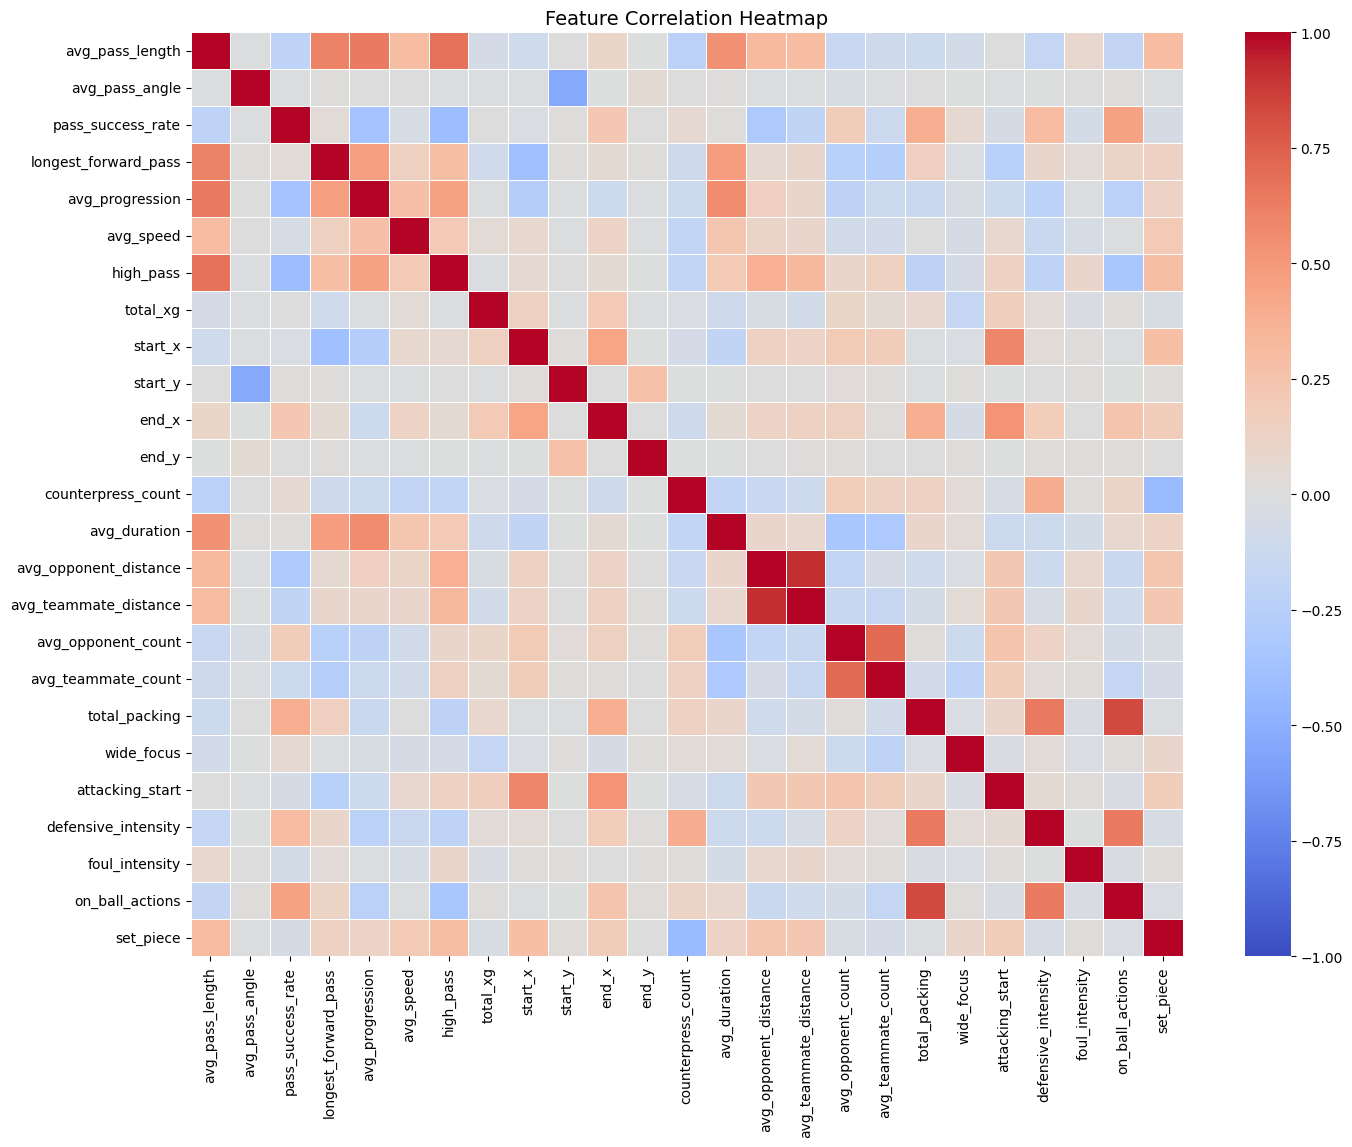

Highly correlated feature pairs (correlation > 0.80):
avg_teammate_distance and avg_opponent_distance: 0.92
on_ball_actions and total_packing: 0.83


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

non_numeric_cols = ['match_id', 'possession', 'play_pattern', 'style', 'style1']

df_play_pattern = pd.get_dummies(possession_features, columns=['play_pattern'])
possession_features['set_piece'] = possession_features['play_pattern'].isin([
    'From Corner', 'From Goal Kick', 'From Free Kick', 'From Kick Off', 'From Throw In'
])

df_numeric = possession_features.drop(columns=non_numeric_cols, errors='ignore')
corr_matrix = df_numeric.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

corr_matrix = df_numeric.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, row, upper_triangle.loc[row, col])
    for col in upper_triangle.columns
    for row in upper_triangle.index
    if upper_triangle.loc[row, col] > 0.80
]

if high_corr_pairs:
    print("Highly correlated feature pairs (correlation > 0.80):")
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1} and {col2}: {corr_value:.2f}")
else:
    print("No feature pairs with correlation greater than 0.80.")


In [27]:
possession_features["possession_dynamics"] = (
    possession_features["avg_progression"] +
    possession_features["avg_speed"] +
    possession_features["high_pass"]
) / 3

possession_features["defensive_aggression"] = (
    possession_features["defensive_intensity"] + possession_features["foul_intensity"]
) / 2

features_to_drop = [
    "avg_progression", "avg_speed", "high_pass", "defensive_intensity",
    "foul_intensity"
]

possession_features.drop(columns=features_to_drop, inplace=True)

In [28]:
df_numeric.columns  

Index(['avg_pass_length', 'avg_pass_angle', 'pass_success_rate',
       'longest_forward_pass', 'avg_progression', 'avg_speed', 'high_pass',
       'total_xg', 'start_x', 'start_y', 'end_x', 'end_y',
       'counterpress_count', 'avg_duration', 'avg_opponent_distance',
       'avg_teammate_distance', 'avg_opponent_count', 'avg_teammate_count',
       'total_packing', 'wide_focus', 'attacking_start', 'defensive_intensity',
       'foul_intensity', 'on_ball_actions', 'set_piece'],
      dtype='object')

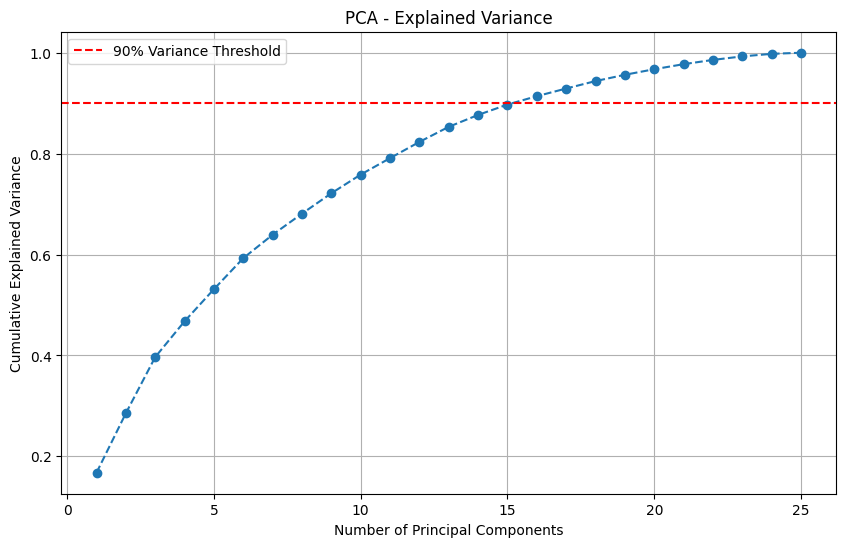

Optimal number of components: 16
PCA Feature Loadings:
                            PC1       PC2       PC3       PC4       PC5  \
avg_pass_length        0.390644  0.091870  0.126449  0.246261  0.009570   
avg_pass_angle         0.000754  0.029299 -0.013210 -0.058110 -0.609524   
pass_success_rate     -0.240637  0.209832  0.158361  0.015356 -0.002906   
longest_forward_pass   0.236664  0.341795  0.086013  0.217114  0.031684   
avg_progression        0.349127  0.143965 -0.047711  0.256171 -0.026836   
avg_speed              0.178024  0.026562  0.138945  0.104403 -0.090210   
high_pass              0.338810 -0.147144  0.087175  0.244983  0.021991   
total_xg              -0.057006 -0.098163  0.109360  0.149217 -0.097737   
start_x               -0.059332 -0.341486  0.297568 -0.090973 -0.048019   
start_y               -0.000614 -0.019053  0.011160  0.053560  0.691744   
end_x                 -0.035752 -0.076465  0.457941  0.061428 -0.065632   
end_y                 -0.004697  0.002482  0.

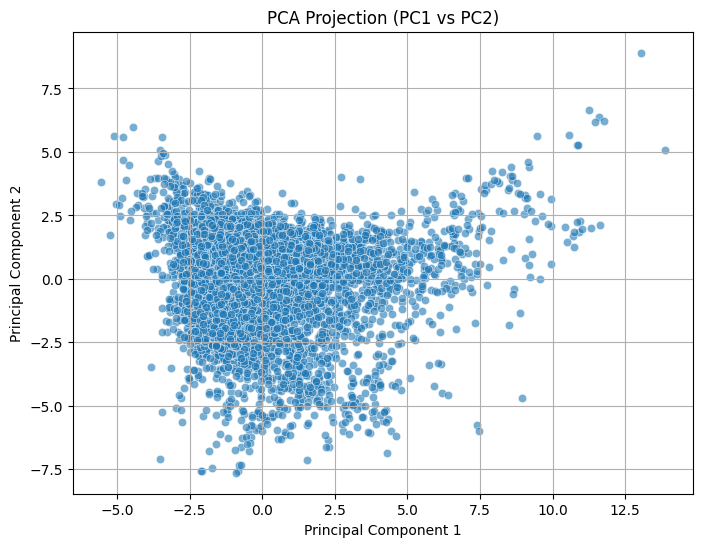

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

# 2️⃣ Apply PCA
pca = PCA()
pca.fit(scaled_features)

# 3️⃣ Plot Explained Variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.legend()
plt.show()

# 4️⃣ Determine the Optimal Number of Components
n_components = np.argmax(explained_variance >= 0.90) + 1  # Selecting components explaining ≥90% variance
print(f"Optimal number of components: {n_components}")

# 5️⃣ Transform Data Using PCA
pca_final = PCA(n_components=n_components)
pca_features = pca_final.fit_transform(scaled_features)

# 6️⃣ Create DataFrame with PCA components
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(n_components)])

# 7️⃣ Analyze Feature Loadings (Contribution of each feature to principal components)
loadings = pd.DataFrame(pca_final.components_.T, index=df_numeric.columns, columns=[f'PC{i+1}' for i in range(n_components)])
print("PCA Feature Loadings:")
print(loadings)

# 8️⃣ Visualize the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (PC1 vs PC2)')
plt.grid()
plt.show()


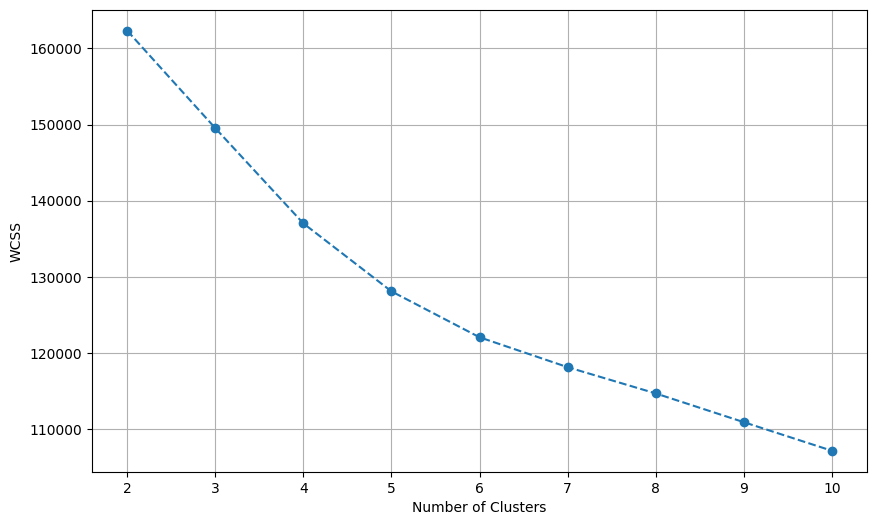

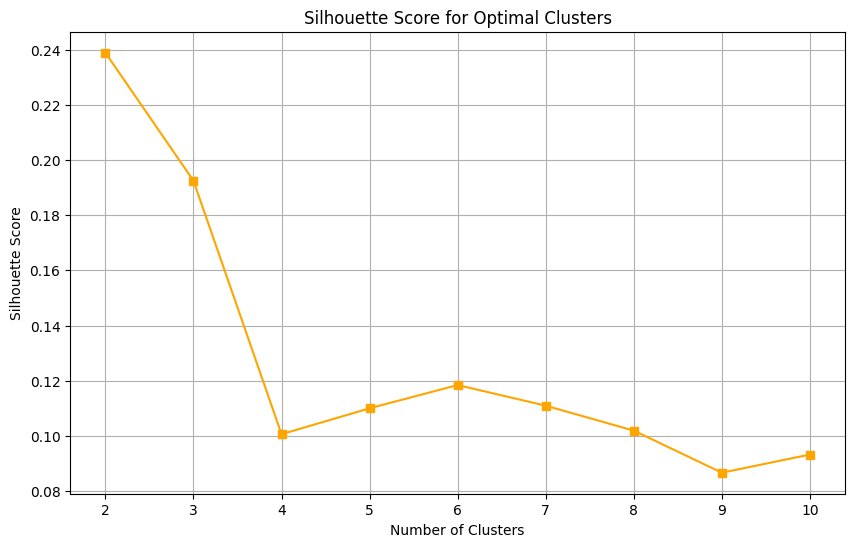

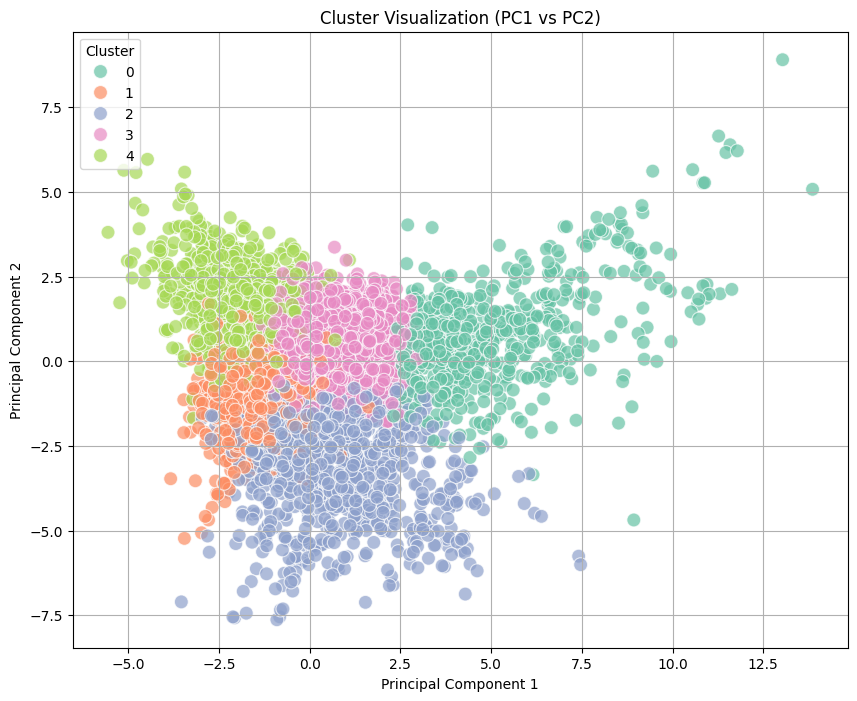

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares

for i in range(2, 11):  # Testing between 2 and 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

# 2️⃣ Silhouette Score to support the elbow method
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='s', linestyle='-', color='orange')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.grid()
plt.show()

# 3️⃣ Apply K-Means with the optimal number of clusters (let's assume 4 based on elbow/silhouette)
optimal_clusters = 5  # Adjust this based on your elbow/silhouette plot results
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)

# Predict clusters
pca_df['Cluster'] = kmeans_final.fit_predict(pca_df)


# 4️⃣ Visualize Clusters in PCA Space
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('Cluster Visualization (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# 5️⃣ Analyze the average feature values per cluster (to profile playing styles)
cluster_profiles = pd.concat([pca_df, df_numeric.reset_index(drop=True)], axis=1)
cluster_summary = cluster_profiles.groupby('Cluster').mean()


In [31]:
possession_features["Cluster"] = pca_df['Cluster']
possession_features.columns

Index(['match_id', 'possession', 'avg_pass_length', 'avg_pass_angle',
       'pass_success_rate', 'longest_forward_pass', 'total_xg', 'start_x',
       'start_y', 'end_x', 'end_y', 'counterpress_count', 'avg_duration',
       'play_pattern', 'avg_opponent_distance', 'avg_teammate_distance',
       'avg_opponent_count', 'avg_teammate_count', 'total_packing',
       'wide_focus', 'attacking_start', 'on_ball_actions', 'set_piece',
       'possession_dynamics', 'defensive_aggression', 'Cluster'],
      dtype='object')

In [32]:
a = possession_features.loc[:,["Cluster", 'avg_pass_length', 'wide_focus', 'attacking_start','total_xg']].groupby(["Cluster"]).describe().T
a

Cluster                         0            1            2            3  \
avg_pass_length count  600.000000  1426.000000  1177.000000  3398.000000   
                mean    56.143283    10.644544    23.026035    23.095723   
                std     18.324939     8.686349    12.786565     7.441035   
                min      7.286288     0.000000     0.000000     0.000000   
                25%     42.055675     0.000000    13.934828    18.090038   
                50%     55.798619    11.147719    22.162329    21.831314   
                75%     69.896334    16.266123    32.798172    26.792816   
                max    107.728780    52.465034    73.625060    72.858490   
wide_focus      count  600.000000  1426.000000  1177.000000  3398.000000   
                mean     0.995161     0.988159     0.835550     1.028008   
                std      0.777685     0.786132     0.675549     0.530934   
                min      0.000000     0.000000     0.000000     0.000000   
                25%      0.000000     0.000000     0.250000     0.666667   
                50%      1.000000     1.000000     0.714286     1.000000   
                75%      1.750000     1.864286     1.333333     1.390700   
                max      2.000000     2.000000     2.000000     2.000000   
attacking_start count  600.000000  1426.000000  1177.000000  3398.000000   
                mean     0.191973     0.151522     0.671431     0.161978   
                std      0.263557     0.186397     0.178738     0.167572   
                min      0.000000     0.000000     0.000000     0.000000   
                25%      0.000000     0.000000     0.550000     0.025000   
                50%      0.000000     0.092330     0.666667     0.111111   
                75%      0.333333     0.250000     0.777778     0.244649   
                max      1.000000     1.000000     1.000000     1.000000   
total_xg        count  600.000000  1426.000000  1177.000000  3398.000000   
                mean     0.001810     0.003583     0.055925     0.006639   
                std      0.022427     0.025060     0.158102     0.031685   
                min      0.000000     0.000000     0.000000     0.000000   
                25%      0.000000     0.000000     0.000000     0.000000   
                50%      0.000000     0.000000     0.000000     0.000000   
                75%      0.000000     0.000000     0.038447     0.000000   
                max      0.442700     0.425219     1.417362     0.481206   

Cluster                          4  
avg_pass_length count  1409.000000  
                mean     18.518976  
                std       3.769829  
                min       9.763868  
                25%      16.096483  
                50%      18.166721  
                75%      20.385689  
                max      41.294572  
wide_focus      count  1409.000000  
                mean      0.951390  
                std       0.335133  
                min       0.000000  
                25%       0.720930  
                50%       0.945455  
                75%       1.180851  
                max       2.000000  
attacking_start count  1409.000000  
                mean      0.301879  
                std       0.179830  
                min       0.000000  
                25%       0.160000  
                50%       0.281481  
                75%       0.426230  
                max       0.906977  
total_xg        count  1409.000000  
                mean      0.031955  
                std       0.090512  
                min       0.000000  
                25%       0.000000  
                50%       0.000000  
                75%       0.024544  
                max       1.239184

In [33]:
cluster_summary.T

Cluster,0,1,2,3,4
PC1,5.064236,-1.328447,0.366803,0.250238,-1.721939
PC2,0.808801,-0.700987,-2.859134,0.557396,1.409152
PC3,-0.132114,-2.110911,1.386316,-0.284448,1.720574
PC4,0.837655,-0.003497,0.034131,-0.272097,0.274528
PC5,-0.015971,0.118563,-0.129372,-0.029129,0.065125
PC6,0.521110,0.713461,-0.397099,-0.473376,0.529353
PC7,0.140116,0.201132,0.061204,-0.206171,0.182860
PC8,-0.206275,-0.160579,-0.018138,0.127256,-0.041388
PC9,-0.282566,-0.277746,-0.126752,0.227250,-0.040741
PC10,0.360953,0.110019,0.185280,-0.172374,-0.004122


In [34]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,Cluster
0,-1.399032,1.422333,1.444638,1.111362,0.218617,0.938779,0.072857,-0.654755,-0.090890,-0.326772,0.533939,-1.092850,-0.067734,1.877699,0.265636,-0.471144,4
1,5.433161,-0.460041,0.806100,-0.555491,0.759545,1.739880,-0.541625,0.587792,-1.242680,-0.101108,-0.959419,-0.214339,0.787257,-0.342900,-0.720637,0.290207,0
2,-1.228019,-0.252926,0.127780,0.175660,-0.129884,0.589101,0.688730,-1.297315,-0.301009,0.336273,1.015131,1.159452,-0.140517,0.241904,0.054926,-0.484897,1
3,0.420490,-0.871496,-0.536458,-0.140385,2.141828,2.333330,-1.115988,0.688047,-1.701375,0.062689,-1.648003,-1.536546,0.638214,-0.191844,-0.317747,-0.175204,1
4,-0.064863,-2.138364,0.422764,0.843675,1.668279,-0.553765,-2.174047,0.079922,-0.534161,0.098418,-0.921699,0.992781,0.957080,0.052862,-0.501959,0.348923,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,5.537772,0.090916,0.643926,-0.343274,-0.579745,1.534302,1.393113,0.012700,0.254193,-0.576731,-0.718726,-0.093683,-1.125180,0.641977,-0.500568,-0.123054,0
8006,0.361647,-0.640954,-2.080851,1.856573,0.762865,0.184167,-0.281850,1.062779,-0.299728,-0.557031,-0.527181,-0.092495,-0.446087,-0.517844,-0.419126,1.909770,1
8007,-0.095989,-0.096849,-1.530174,0.927434,1.215069,-1.381195,-0.291544,-0.219977,1.274952,-1.018419,-0.379820,0.478795,-0.451700,1.298243,0.792103,-0.325937,3
8008,4.680817,-2.570929,2.129655,-1.853500,1.186181,4.558264,-1.186866,3.589038,4.394264,3.841647,0.570493,-0.057781,0.516251,-0.304921,-0.378103,-0.158852,0


In [35]:
possession_features['Cluster'] = pca_df['Cluster']
df_event_with_clusters = df_event.merge(
    possession_features[['match_id', 'possession', 'Cluster']],
    on=['match_id', 'possession'],
    how='left')

In [36]:
# 2️⃣ Calculate Cluster Distribution per Team
team_playing_styles = df_event_with_clusters.groupby(['team_name', 'Cluster']).size().unstack(fill_value=0)


# Normalize to get percentages
team_playing_styles_percentage = team_playing_styles.div(team_playing_styles.sum(axis=1), axis=0) * 100

team_playing_styles_percentage




Cluster,0,1,2,3,4
team_name,,,,,
Albania,2.105507,12.239704,5.691809,38.431282,41.531698
Austria,1.123900,9.505755,7.285037,37.210562,44.874746
Belgium,0.911528,6.072386,5.348525,48.806971,38.860590
Croatia,0.771828,8.264994,4.711368,29.393793,56.858016
Czech Republic,3.285471,9.686055,12.071064,42.784132,32.173278
Denmark,1.199592,9.443594,5.206738,34.839204,49.310873
England,1.472557,7.215529,3.942436,27.958501,59.410977
France,0.730547,7.611281,7.670744,35.312606,48.674822
Georgia,2.846648,11.606979,8.686869,43.360882,33.498623


<Figure size 1200x800 with 0 Axes>

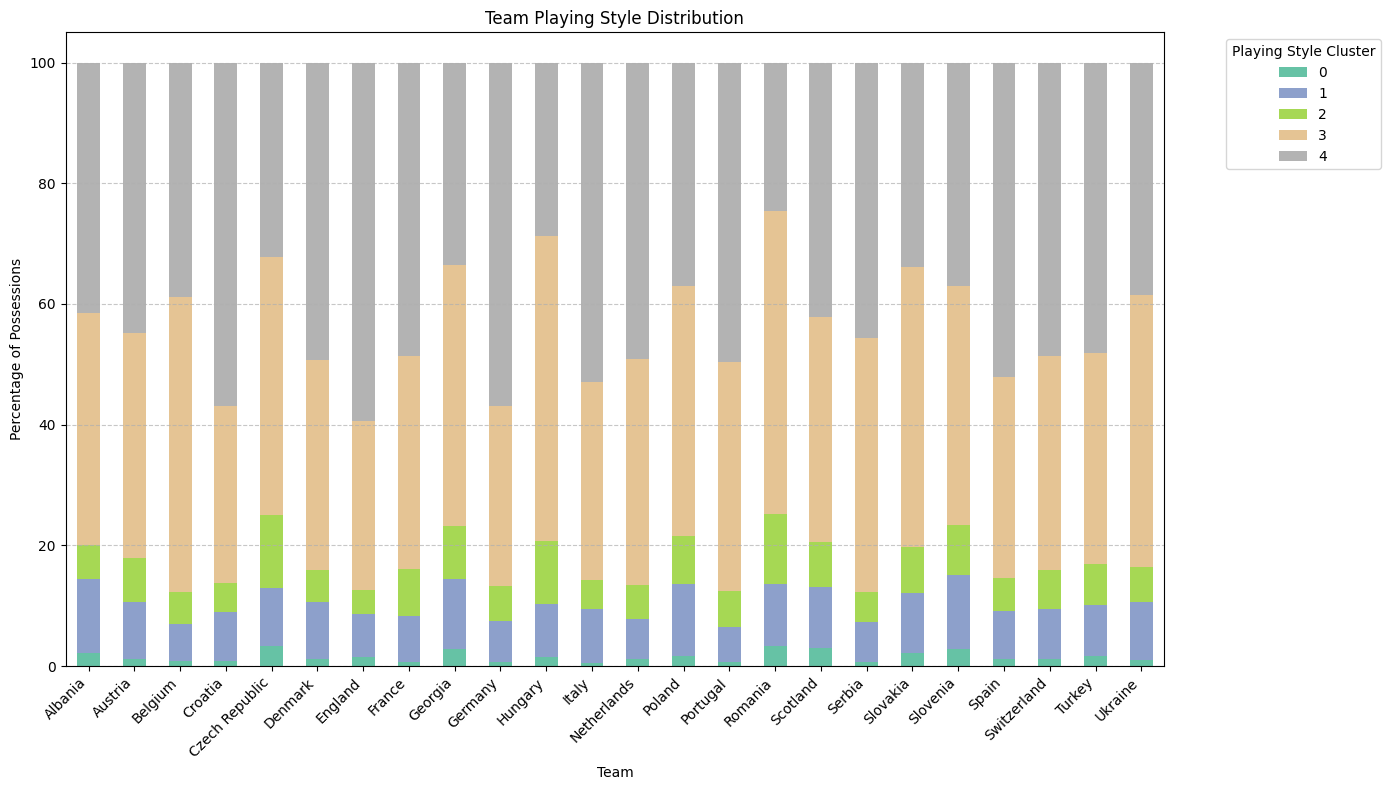

In [37]:
import matplotlib.pyplot as plt

# 3️⃣ Stacked Bar Plot for Team Playing Styles
plt.figure(figsize=(12, 8))
team_playing_styles_percentage.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2')

plt.title('Team Playing Style Distribution')
plt.xlabel('Team')
plt.ylabel('Percentage of Possessions')
plt.legend(title='Playing Style Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


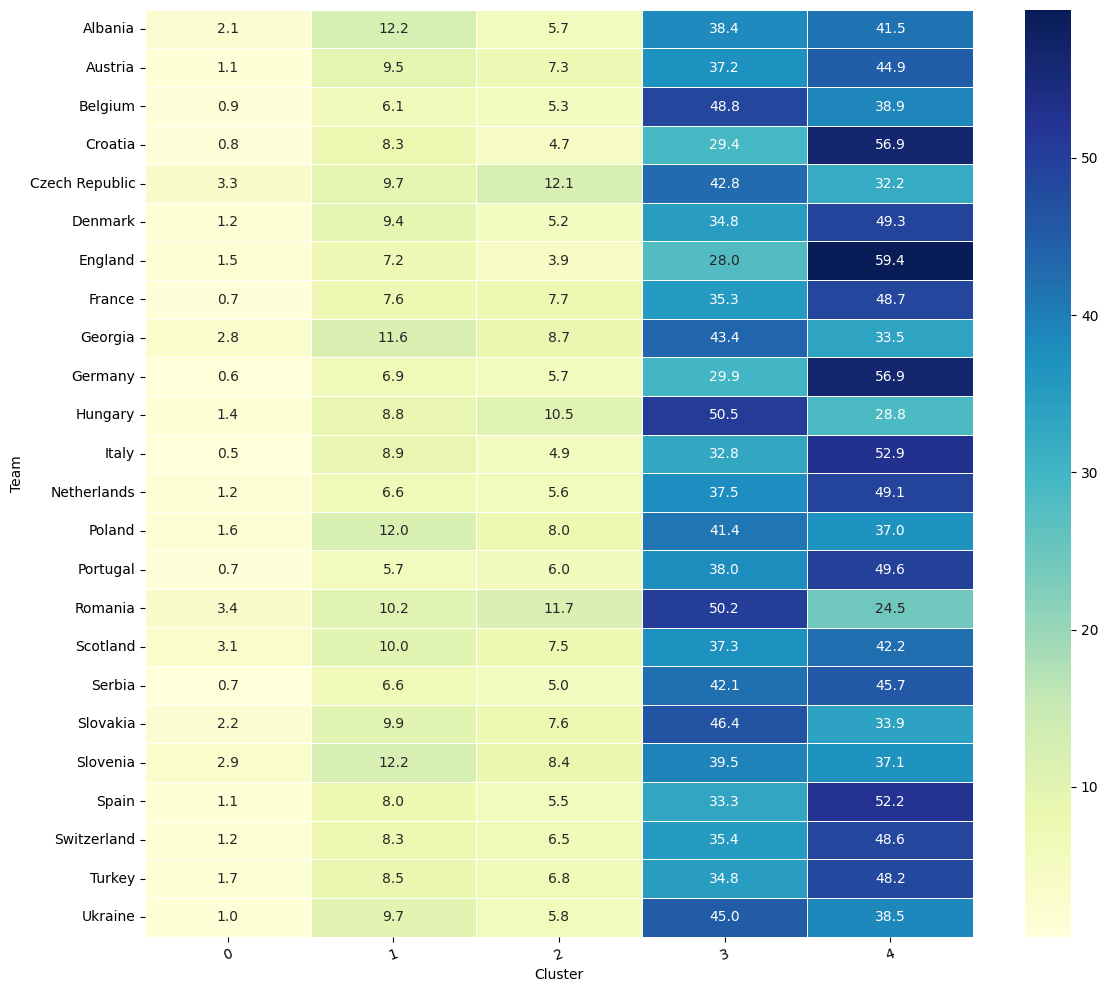

In [38]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(team_playing_styles_percentage, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)

plt.ylabel('Team')
plt.tight_layout()

plt.xticks(rotation=20)

plt.show()


In [39]:
# 1️⃣ Mapping Cluster Numbers to Style Names
cluster_to_style = {
    0: 'High long ball from defense',
    1: 'Build-up against high press',
    2: 'Set pieces or crosses close to goal',
    3: 'Regular attack transition',
    4: 'Long possession during build-up'
}

# Apply the mapping
team_playing_styles_percentage.rename(columns=cluster_to_style, inplace=True)


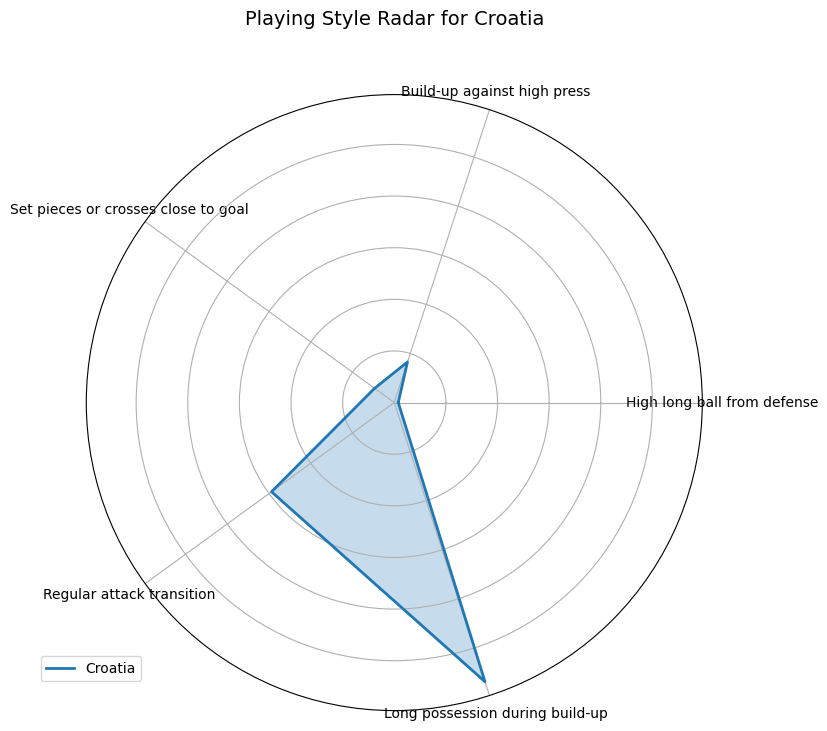

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 2️⃣ Radar Plot Function
def plot_team_playing_style_radar(team_name, data):
    styles = data.columns.tolist()
    values = data.loc[team_name].values.tolist()

    # Close the radar plot
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(styles), endpoint=False).tolist()
    angles += angles[:1]

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=team_name)
    ax.fill(angles, values, alpha=0.25)

    # Setting labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(styles, fontsize=10)
    ax.set_yticklabels([])  # Remove radial ticks for clarity

    plt.title(f'Playing Style Radar for {team_name}', size=14, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Example: Plotting for a specific team
plot_team_playing_style_radar('Croatia', team_playing_styles_percentage)


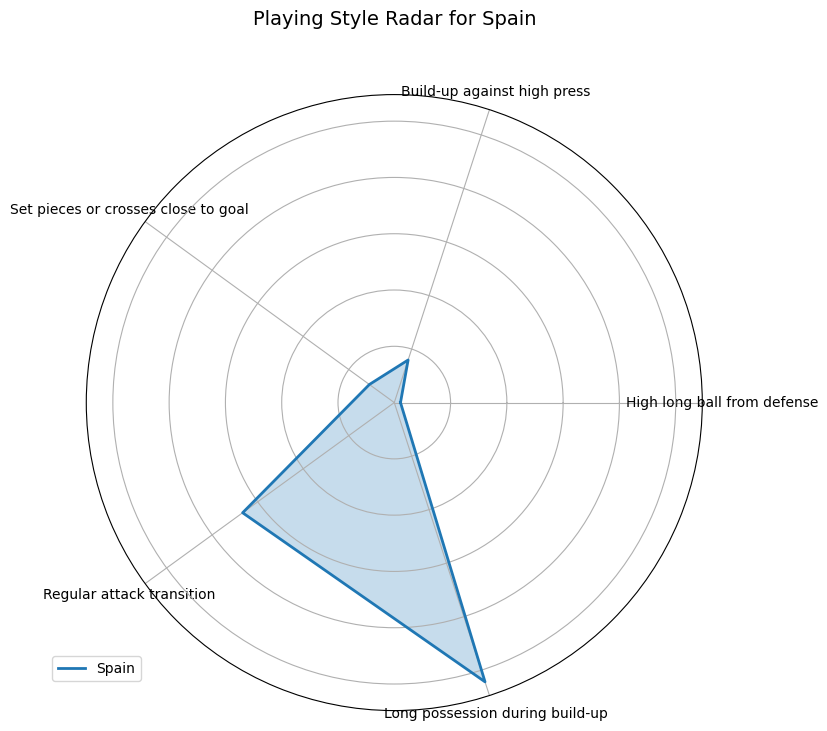

In [41]:
plot_team_playing_style_radar('Spain', team_playing_styles_percentage)

In [42]:
possession_features

,match_id,possession,avg_pass_length,avg_pass_angle,pass_success_rate,longest_forward_pass,total_xg,start_x,start_y,end_x,...,avg_opponent_count,avg_teammate_count,total_packing,wide_focus,attacking_start,on_ball_actions,set_piece,possession_dynamics,defensive_aggression,Cluster
0,3930158,2,22.029285,-0.231196,0.875,50.6,0.0,61.0,40.1,97.1,...,1.500000,1.134615,23,0.421053,0.105263,32,True,4.445382,3.5,4
1,3930158,3,61.134686,0.305715,0.000,58.3,0.0,37.6,48.4,78.3,...,1.000000,0.800000,6,1.800000,0.200000,2,True,8.852193,0.5,0
2,3930158,4,19.156008,-0.531913,1.000,19.0,0.0,50.1,25.7,103.8,...,1.666667,1.083333,15,0.833333,0.416667,7,False,3.782837,1.5,1
3,3930158,5,16.172764,0.076130,0.000,29.2,0.0,28.5,80.0,62.1,...,1.812500,1.875000,15,2.000000,0.000000,5,True,2.644218,3.0,1
4,3930158,6,15.551220,-0.371802,1.000,21.0,0.0,56.7,80.0,87.7,...,3.857143,0.857143,6,1.750000,0.500000,3,True,2.694696,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,3943043,143,56.069687,0.195647,0.000,55.0,0.0,26.1,21.1,81.1,...,0.000000,0.000000,7,0.000000,0.333333,1,True,9.007065,0.5,0
8006,3943043,144,21.258494,-0.225337,0.500,26.0,0.0,39.0,48.1,40.7,...,2.125000,1.750000,10,0.636364,0.000000,5,False,3.228477,0.5,1
8007,3943043,145,36.442420,-0.915770,1.000,22.2,0.0,40.9,66.3,57.9,...,1.800000,1.000000,0,0.166667,0.000000,1,True,2.371826,1.0,3
8008,3943043,146,53.496635,0.444419,0.000,48.3,0.0,57.5,36.0,105.5,...,1.000000,0.500000,0,1.111111,0.555556,2,True,2.866521,2.5,0


In [43]:
from requests import Session
from sql_schemas import Possessions


def init_possessions(db: Session, df, tableClass = Possessions):
    db.query(tableClass).delete()
    db.commit()
    new_rows = [
        tableClass(
            match_id=p['match_id'], possession=p['possession'], 
            playing_style=cluster_to_style.get(p['playing_style']),
            passes=p['Pass'],
            carry=p['Carry'],
            dribble=p['Dribble'],
            shot=p['Shot'],
            duel=p['Duel'],
            pressure=p['Pressure'],
            block=p['Block'],
            ball_recovery=p['Ball Recovery'],
            interception=p['Interception'],
            clearance=p['Clearance'],
            avg_pass_length=p['avg_pass_length'],
            pass_success_rate=p['pass_success_rate'],
            possession_team_name=p['possession_team_name']
        )
        for p in df.to_dict(orient="records")
    ]
    print(new_rows)
    if new_rows:
        db.bulk_save_objects(new_rows)
    db.commit()

In [44]:
db.rollback()

In [45]:
possession_features_original['Cluster'] = possession_features['Cluster']
possession_features_original.to_csv('test.csv')



In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you already have X and cluster labels
X = pd.read_csv('test.csv')



In [62]:
df = possession_features_original
df['playing_style'] = df['Cluster']
possession_team = event_df.groupby(['match_id', 'possession'])['possession_team_name'].max().reset_index()
possession_team
df = df.merge(possession_team[['match_id', 'possession', 'possession_team_name']], on=['match_id', 'possession'], how='left')
df
#df_final = df.rename(columns={"Pass": "passes"})
#df_final

init_possessions(db,df)

[<sql_schemas.Possessions object at 0x000002543DD0CD40>, <sql_schemas.Possessions object at 0x000002544B52F770>, <sql_schemas.Possessions object at 0x000002544B52F7A0>, <sql_schemas.Possessions object at 0x00000254578C3BF0>, <sql_schemas.Possessions object at 0x00000254578C3D40>, <sql_schemas.Possessions object at 0x00000254578C3D70>, <sql_schemas.Possessions object at 0x00000254726C8F80>, <sql_schemas.Possessions object at 0x00000254437473E0>, <sql_schemas.Possessions object at 0x000002540FEFF7D0>, <sql_schemas.Possessions object at 0x000002540FEFF5F0>, <sql_schemas.Possessions object at 0x000002540FEFE330>, <sql_schemas.Possessions object at 0x000002540FEFF410>, <sql_schemas.Possessions object at 0x000002540FEFFBF0>, <sql_schemas.Possessions object at 0x000002540FEFFE90>, <sql_schemas.Possessions object at 0x000002540FEFD0A0>, <sql_schemas.Possessions object at 0x000002540FEFF8F0>, <sql_schemas.Possessions object at 0x000002540FEFF890>, <sql_schemas.Possessions object at 0x000002540F

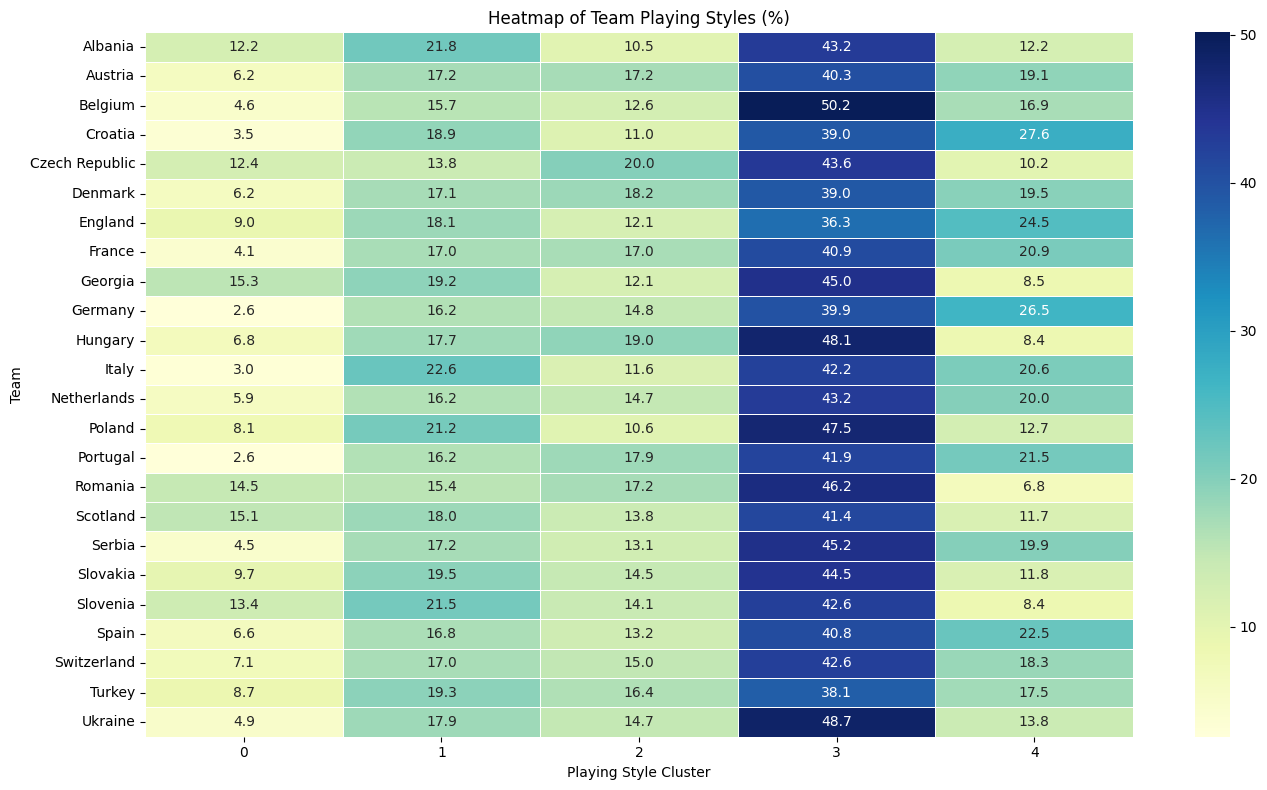

In [48]:

team_possessions = df.groupby(['possession_team_name', 'Cluster']).size().unstack(fill_value=0)


# Normalize to get percentages
team_possessions_percentage = team_possessions.div(team_possessions.sum(axis=1), axis=0) * 100
plt.figure(figsize=(14, 8))
sns.heatmap(team_possessions_percentage, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)

plt.title('Heatmap of Team Playing Styles (%)')
plt.xlabel('Playing Style Cluster')
plt.ylabel('Team')
plt.tight_layout()

plt.show()


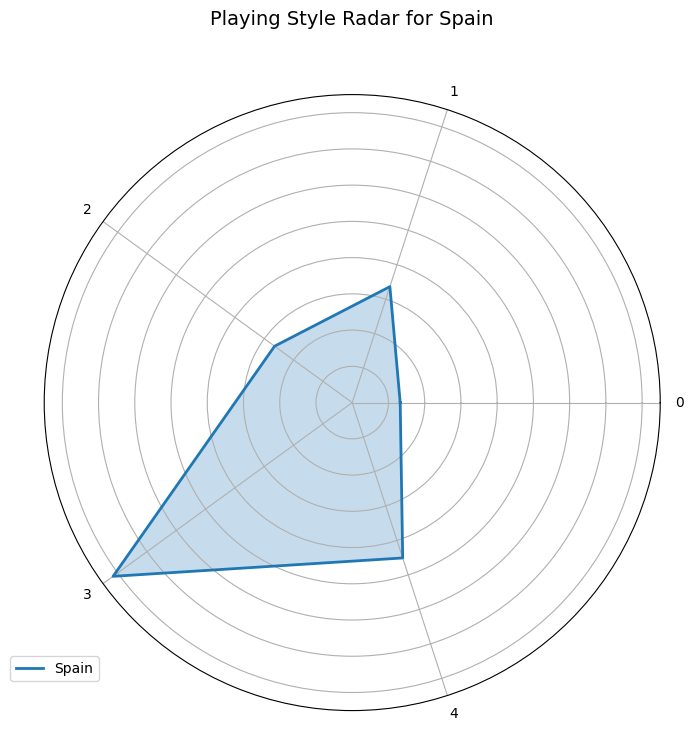

In [49]:
plot_team_playing_style_radar('Spain', team_possessions_percentage)

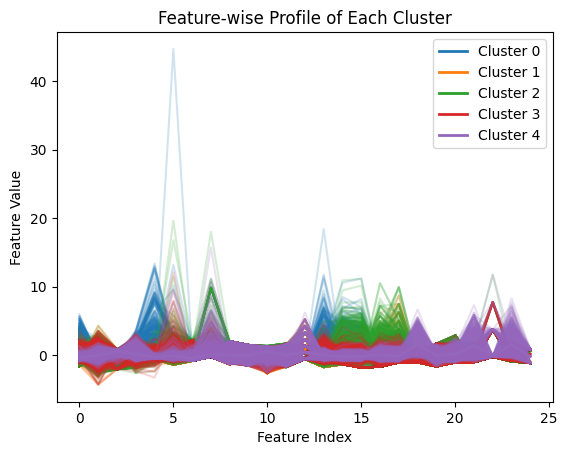

In [50]:
# Cluster
df_numeric['Cluster'] = df['Cluster']
labels = df['Cluster']

for cluster_id in np.unique(labels):
    cluster_points = scaled_features[labels == cluster_id]
    for row in cluster_points:
        plt.plot(row, alpha=0.2, color=f'C{cluster_id}')
    plt.plot(cluster_points.mean(axis=0), color=f'C{cluster_id}', label=f'Cluster {cluster_id}', linewidth=2)

plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.title("Feature-wise Profile of Each Cluster")
plt.legend()
plt.show()

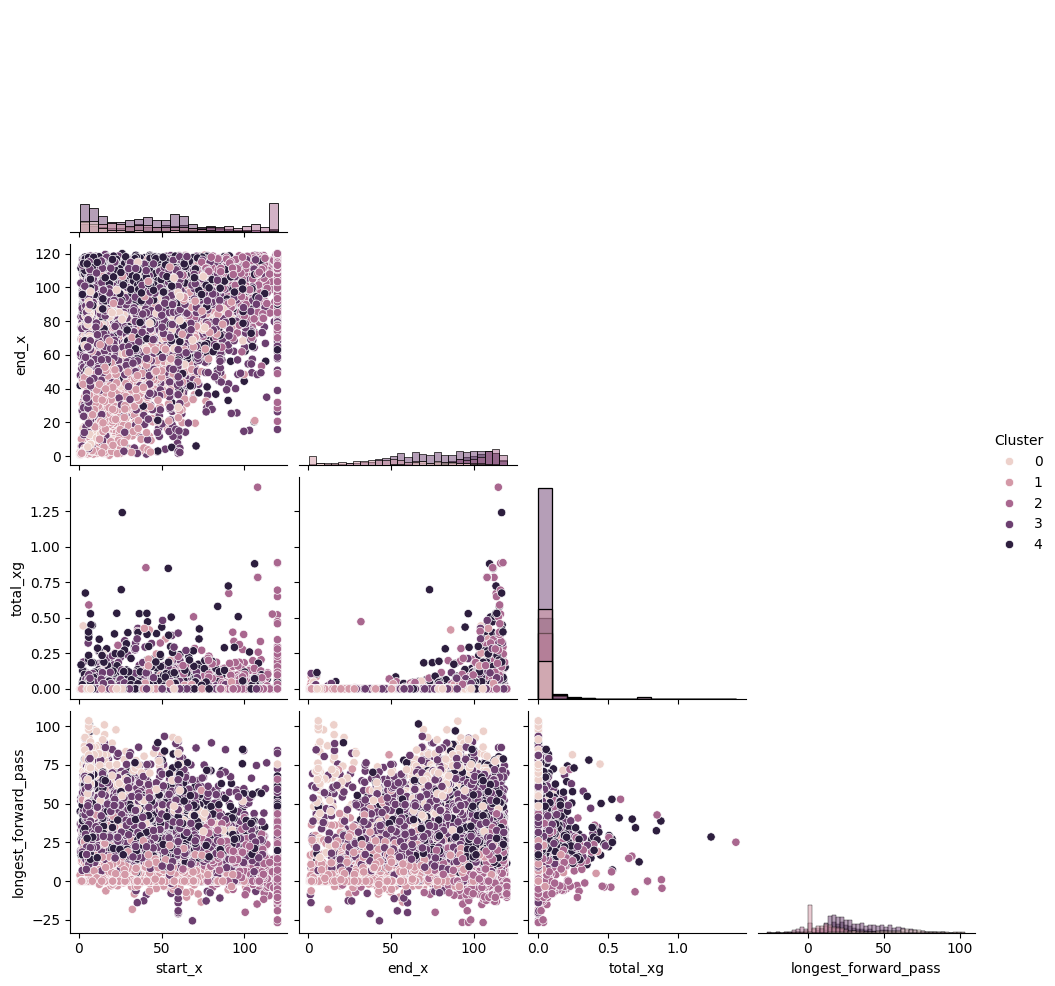

In [51]:
sns.pairplot(df_numeric.loc[:,['start_x', 'end_x', 'total_xg', 'longest_forward_pass', 'Cluster']], hue='Cluster', corner=True, diag_kind='hist')

(5, 16)


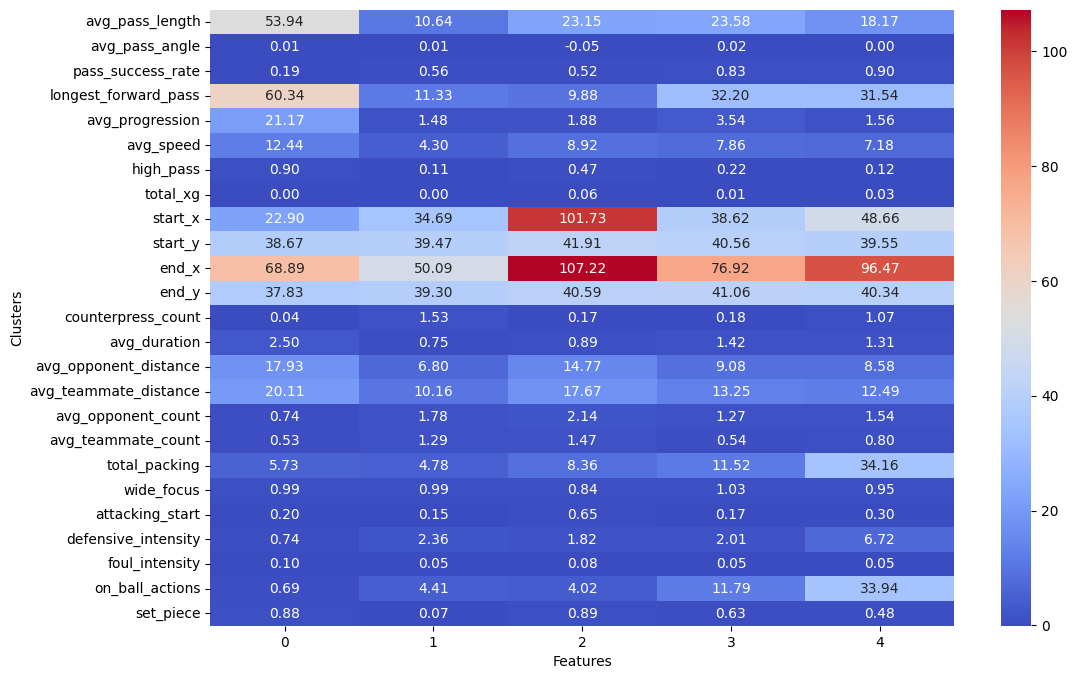

In [52]:
centers = kmeans_final.cluster_centers_
print(centers.shape) 
centers_original_space = pca_final.inverse_transform(centers)
cluster_centers_orig = scaler.inverse_transform(centers_original_space)

columns = [col for col in df_numeric.columns if col != 'Cluster']
df_centers = pd.DataFrame(cluster_centers_orig, columns=columns)

plt.figure(figsize=(12, 8))
sns.heatmap(df_centers.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

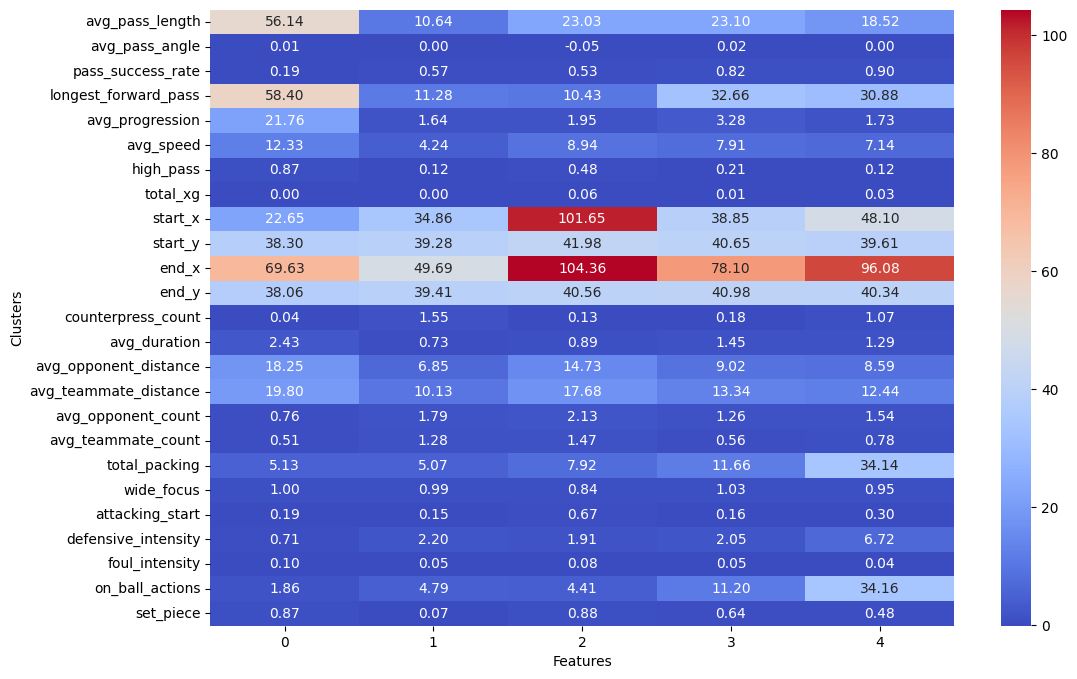

Index([0, 1, 2, 3, 4], dtype='int32', name='Cluster')

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
cluster_summary_cleaned = cluster_summary.loc[:, ~cluster_summary.columns.str.startswith('PC')]
plt.figure(figsize=(12, 8))  # adjust size as needed
sns.heatmap(cluster_summary_cleaned.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()
cluster_summary.T.columns

[[-0.03594175 -0.32439256  0.50344963 ... -0.22529772  1.41677323
   0.88452049]
 [ 2.72026535  0.42013725 -2.03406211 ... -0.22529772 -0.75155005
   0.88452049]
 [-0.23845455 -0.74139293  0.8659513  ... -0.22529772 -0.39016284
  -1.13055606]
 ...
 [ 0.97991755 -1.27368447  0.8659513  ... -0.22529772 -0.8238275
   0.88452049]
 [ 2.1819241   0.61247758 -2.03406211 ...  7.75981157 -0.75155005
   0.88452049]
 [ 3.85969343  0.32025194 -2.03406211 ...  3.76725693 -0.8238275
   0.88452049]]


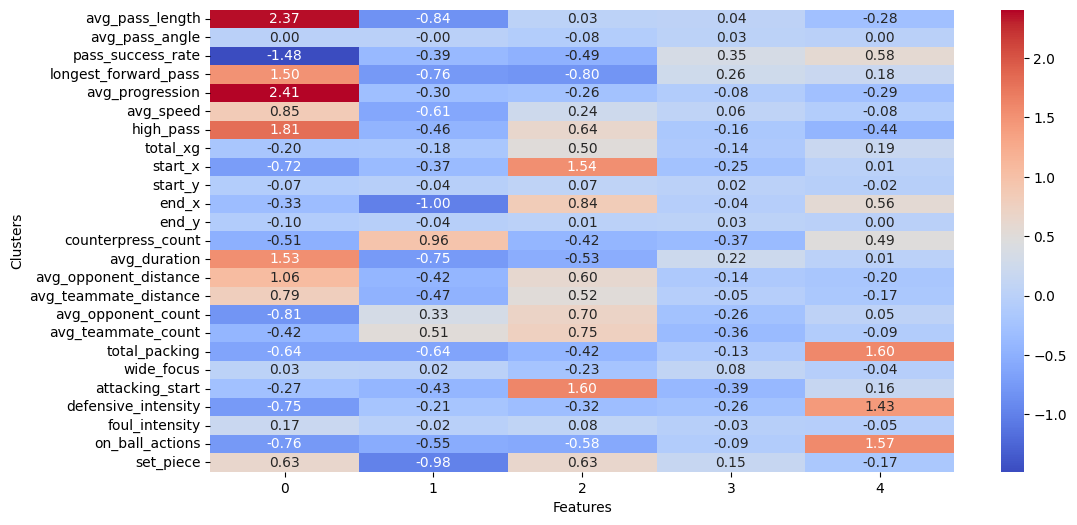

In [54]:
from pandas import DataFrame

print(scaled_features)
cluster_profiles = pd.DataFrame(scaled_features, columns=df_numeric.columns[:-1], index=df_numeric.index)
cluster_profiles['Cluster'] = df_numeric['Cluster']
cluster_summary = cluster_profiles.groupby('Cluster').mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

In [55]:
df_event_with_clusters.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'match_id', 'type_id',
       ...
       'width_change', 'speed', 'distance_covered', 'angle_change',
       'nearby_opponents', 'nearby_teammates', 'teammate_distance',
       'opponent_distance', 'packing', 'Cluster'],
      dtype='object', length=102)

In [56]:
df_event_with_clusters.loc[:,['type_name','player_name','position_name','Cluster']]
df_event_with_clusters = df_event_with_clusters[df_event_with_clusters['position_name'].str.contains("Forward", na=False)]

In [57]:
a = df_event_with_clusters.groupby(['player_name', 'Cluster'])['type_name'].value_counts().reset_index()

b = df_event_with_clusters[df_event_with_clusters['type_name'] == 'Pass'].groupby(['player_name', 'Cluster'])['outcome_name'].apply(lambda g: g.isna().mean()).reset_index()
a[a['Cluster'] == 4].sort_values(by='count', ascending=False).head(20)

,player_name,Cluster,type_name,count
1085,Harry Kane,4,Ball Receipt,98
2716,Álvaro Borja Morata Martín,4,Ball Receipt,96
1350,Kai Havertz,4,Ball Receipt,89
639,Cristiano Ronaldo dos Santos Aveiro,4,Ball Receipt,86
1817,Memphis Depay,4,Ball Receipt,82
1561,Kylian Mbappé Lottin,4,Ball Receipt,79
2208,Rasmus Winther Højlund,4,Ball Receipt,73
1086,Harry Kane,4,Carry,64
484,Breel-Donald Embolo,4,Ball Receipt,61
1562,Kylian Mbappé Lottin,4,Carry,61


In [58]:
a = a.merge(b, on=['player_name', 'Cluster'], how='left')

In [59]:
c = a[a['type_name'] == 'Dribble'][a['count']> 3]
c.sort_values(by='outcome_name', ascending=False).head(20)

,player_name,Cluster,type_name,count,outcome_name
415,Benjamin Šeško,2,Dribble,4,1.000000
1465,Khvicha Kvaratskhelia,4,Dribble,5,0.947368
232,Arda Güler,4,Dribble,4,0.913043
1564,Kylian Mbappé Lottin,4,Dribble,10,0.909091
949,Georges Mikautadze,4,Dribble,7,0.875000
1454,Khvicha Kvaratskhelia,3,Dribble,4,0.857143
1433,Khvicha Kvaratskhelia,1,Dribble,5,0.800000
1554,Kylian Mbappé Lottin,3,Dribble,5,0.777778
935,Georges Mikautadze,3,Dribble,7,0.756098
915,Georges Mikautadze,1,Dribble,4,0.750000


In [60]:
df_play_pattern

,match_id,possession,avg_pass_length,avg_pass_angle,pass_success_rate,longest_forward_pass,avg_progression,avg_speed,high_pass,total_xg,...,on_ball_actions,play_pattern_From Corner,play_pattern_From Counter,play_pattern_From Free Kick,play_pattern_From Goal Kick,play_pattern_From Keeper,play_pattern_From Kick Off,play_pattern_From Throw In,play_pattern_Other,play_pattern_Regular Play
0,3930158,2,22.029285,-0.231196,0.875,50.6,1.426316,11.792182,0.117647,0.0,...,32,False,False,False,False,False,True,False,False,False
1,3930158,3,61.134686,0.305715,0.000,58.3,15.180000,10.376578,1.000000,0.0,...,2,False,False,True,False,False,False,False,False,False
2,3930158,4,19.156008,-0.531913,1.000,19.0,4.941667,6.406844,0.000000,0.0,...,7,False,False,False,False,False,False,False,False,True
3,3930158,5,16.172764,0.076130,0.000,29.2,3.387500,3.878486,0.666667,0.0,...,5,False,False,False,False,False,False,True,False,False
4,3930158,6,15.551220,-0.371802,1.000,21.0,3.662500,3.421589,1.000000,0.0,...,3,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8005,3943043,143,56.069687,0.195647,0.000,55.0,18.333333,7.687861,1.000000,0.0,...,1,False,False,True,False,False,False,False,False,False
8006,3943043,144,21.258494,-0.225337,0.500,26.0,4.336364,4.349067,1.000000,0.0,...,5,False,False,False,False,False,False,False,False,True
8007,3943043,145,36.442420,-0.915770,1.000,22.2,3.700000,3.415477,0.000000,0.0,...,1,False,False,True,False,False,False,False,False,False
8008,3943043,146,53.496635,0.444419,0.000,48.3,5.133333,2.466228,1.000000,0.0,...,2,False,False,True,False,False,False,False,False,False
